In [1]:
import logging

import numpy as np
import os
import pathlib
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

tf.get_logger().setLevel(logging.ERROR)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

2024-04-24 16:21:51.917578: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 16:21:51.917841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 16:21:52.020390: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 16:21:52.262437: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 16:21:53.673820: W tensorflow/compiler/tf2

Подсчитаем общее количество изображений:

In [2]:
data_dir = pathlib.Path("images")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

19794


Взглянем на одно из изображений:

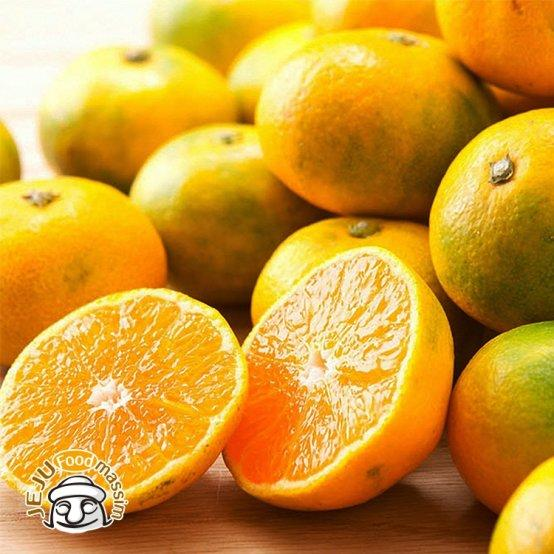

In [3]:
fruits = list(data_dir.glob('фрукты/*'))
PIL.Image.open(fruits[0])

Определим параметры - размер пакета (batch), высоту и ширину изображений:

In [5]:
batch_size = 32
img_height = 256
img_width = 256

Загрузим наши данные, выделив для обучения 70%:

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.30,
  subset="training",
  label_mode='categorical',  
  seed=2,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 19794 files belonging to 40 classes.
Using 13856 files for training.


Для валидации загрузим оставшиеся 30%:

In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.30,
  subset="validation",
  label_mode='categorical',   
  seed=2,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 19794 files belonging to 40 classes.
Using 5938 files for validation.


Разделим валидационные данные на тестовую и валидационную выборки:

In [9]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((val_batches) // 2)
val_ds = val_ds.skip((val_batches) // 2)

Взглянем на несколько изображений:

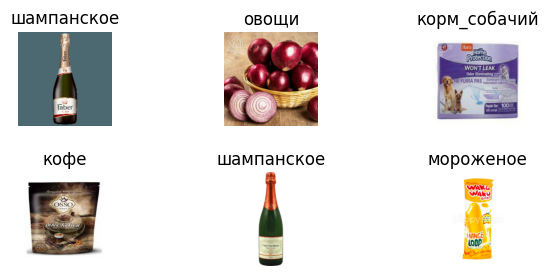

In [10]:
class_names = train_ds.class_names

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(2):
  for i in range(6):  
    label = class_names[np.argmax(labels[i])]
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(label)
    plt.axis("off")
    plt.subplots_adjust(left=None, bottom=None, right=1.1, top=0.5, wspace=None, hspace=0.5)

Зададим архитектуру нашей модели:

In [11]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.Input(shape=(img_width, img_height, 3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 5, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.4),  
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.4),   
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

Определим коллбэки:

In [12]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

In [13]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoints/simple_model.weights.h5",
    save_weights_only=True)

In [14]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
  metrics=['accuracy']  
)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 252, 252, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9

Запустим обучение:

In [16]:
%%time
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[checkpoint_cb, es]
)

Epoch 1/10


2024-04-24 16:23:04.137311: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-24 16:23:04.373941: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-24 16:23:05.893490: I external/local_xla/xla/service/service.cc:168] XLA service 0x7e8d288f4860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-24 16:23:05.893515: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-04-24 16:23:05.916030: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713950586.063529  114934 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


433/433 [==============================] - 31s 59ms/step - loss: 3.4567 - accuracy: 0.0920 - val_loss: 2.9661 - val_accuracy: 0.2113
Epoch 2/10
433/433 [==============================] - 25s 57ms/step - loss: 2.7820 - accuracy: 0.2458 - val_loss: 2.4602 - val_accuracy: 0.3494
Epoch 3/10
433/433 [==============================] - 25s 57ms/step - loss: 2.2796 - accuracy: 0.3720 - val_loss: 2.2595 - val_accuracy: 0.4163
Epoch 4/10
433/433 [==============================] - 25s 58ms/step - loss: 1.8152 - accuracy: 0.4851 - val_loss: 2.1330 - val_accuracy: 0.4473
Epoch 5/10
433/433 [==============================] - 25s 58ms/step - loss: 1.3877 - accuracy: 0.6039 - val_loss: 2.1460 - val_accuracy: 0.4669
Epoch 6/10
433/433 [==============================] - 26s 60ms/step - loss: 1.0869 - accuracy: 0.6850 - val_loss: 2.1977 - val_accuracy: 0.4686
Epoch 7/10
433/433 [==============================] - 25s 58ms/step - loss: 0.8797 - accuracy: 0.7455 - val_loss: 2.1602 - val_accuracy: 0.4875
Epo

Протестируем модель на нашей тестовой выборке:

In [17]:
results = model.evaluate(test_ds)

93/93 [==============================] - 3s 28ms/step - loss: 2.4956 - accuracy: 0.4634


In [18]:
results

[2.4955978393554688, 0.46337366104125977]

In [19]:
predictions = model.predict(test_ds)

93/93 [==============================] - 3s 27ms/step


Иллюстрация того, какие классы были предсказаны для разных изображений. \
В скобках указан предсказанный класс

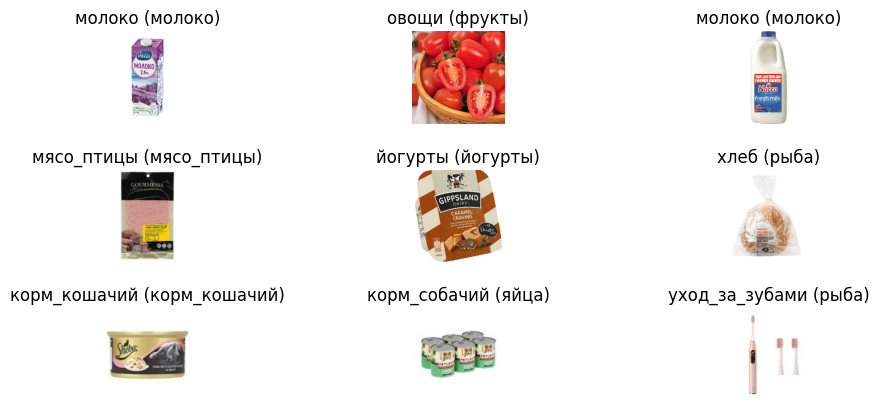

In [20]:
IMAGE_NUM = 2
for i, (images, labels) in enumerate(test_ds):
    if i == 9:
        break
    ax = plt.subplot(3, 3, i + 1)
    im = np.expand_dims(images[IMAGE_NUM].numpy(), axis=0)
    prediction = class_names[np.argmax(model.predict(im, verbose=0)[0])]
    plt.imshow(images[IMAGE_NUM, ...].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels.numpy()[IMAGE_NUM])] + f' ({prediction})')
    plt.axis("off")
    plt.subplots_adjust(left=None, bottom=None, right=1.5, top=None, wspace=None, hspace=0.5)

Построим матрицу ошибок:

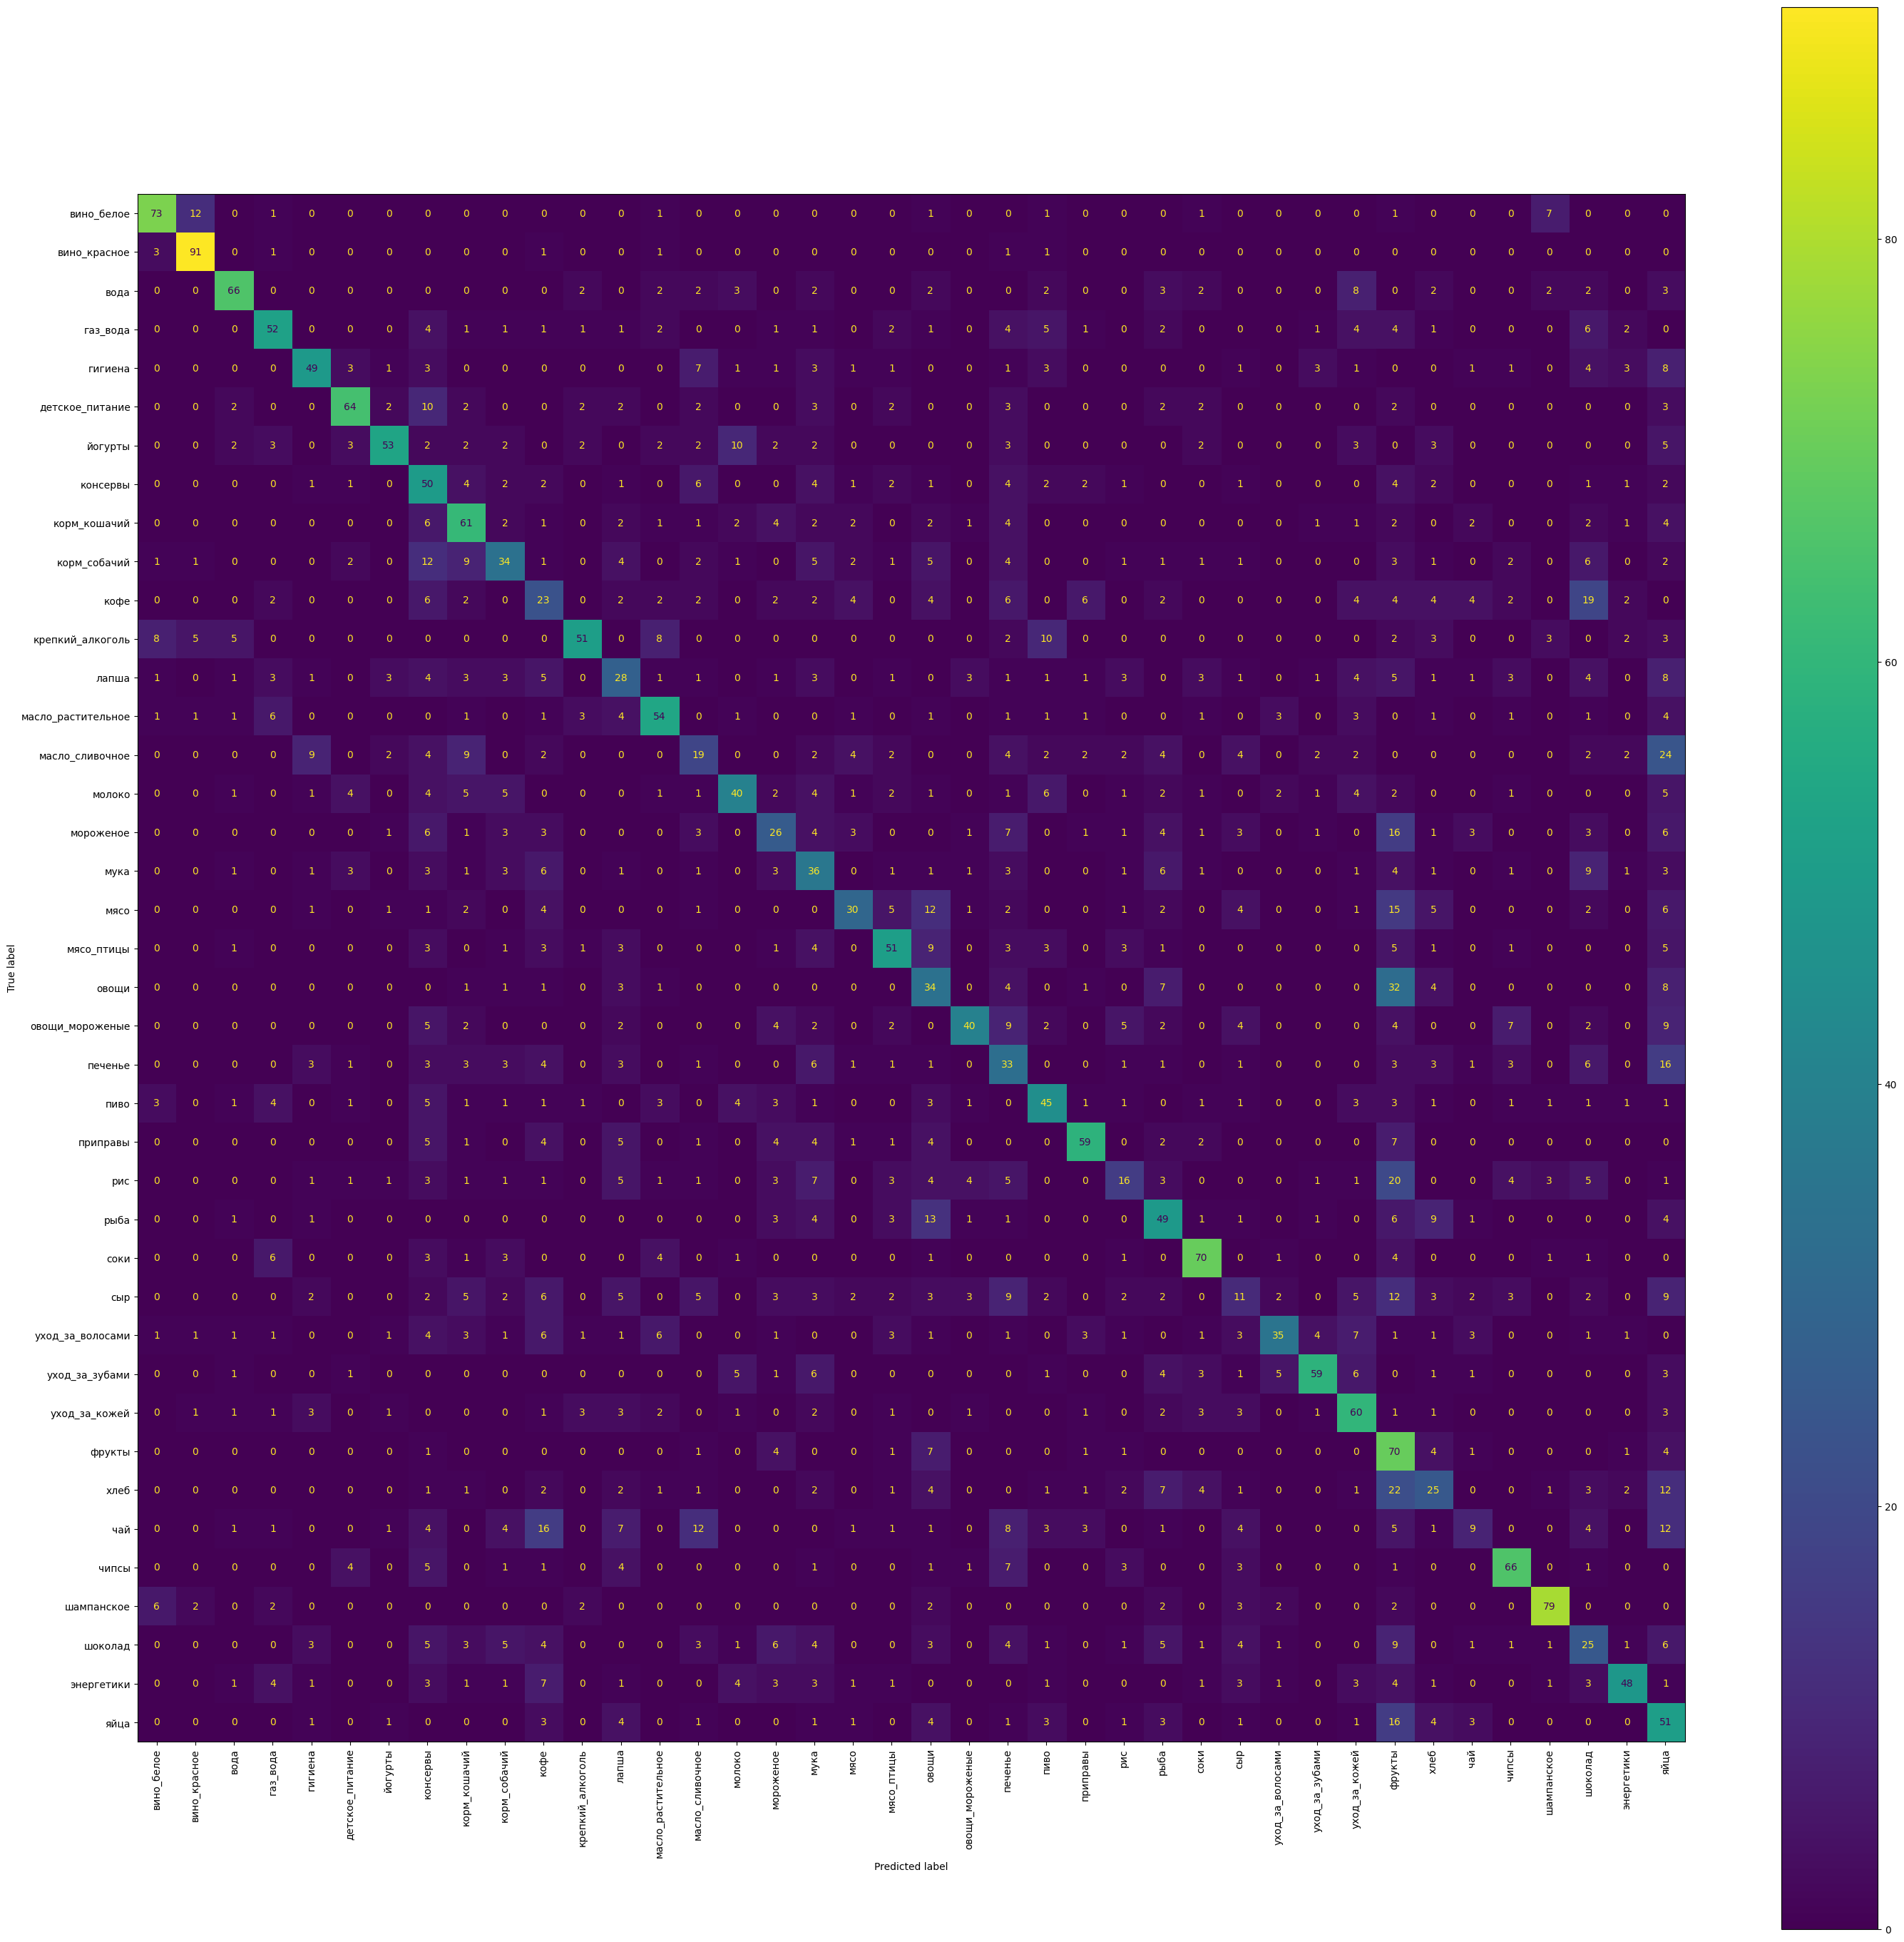

In [21]:
from utils.confusion_matrix import plot_confusion_matrix

plot_confusion_matrix(model, test_ds, train_ds.class_names)

Сохраним натренированную модель:

In [22]:
model.save('ready_models/simple_model.keras')

In [23]:
import json

with open('models_histories/simple_model.json', 'w') as f:
    json.dump(history.history, f, indent=4)

Text(0, 0.5, 'Валидационная точность')

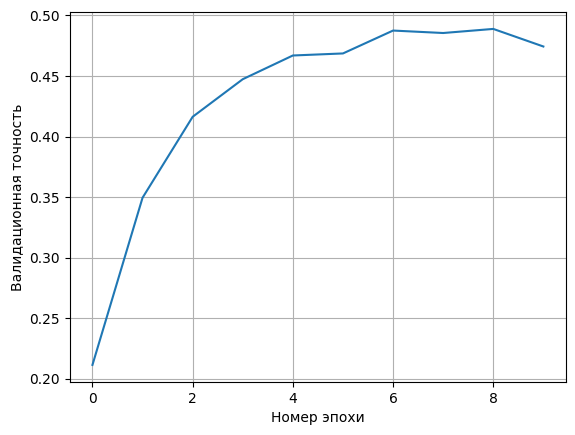

In [24]:
plt.plot(range(len(history.history['accuracy'])), history.history['val_accuracy'])
plt.grid()
plt.xlabel('Номер эпохи')
plt.ylabel('Валидационная точность')